<h1><center><b>LMTSC-IOD: Lightweight Multivariate Time-Series Classification for Indoor-Outdoor Detection</center></h1></b>
<h2><center><b> MAGNET DATASET</center></h2></b>


<h2><b>  Author:</h2></b>

        Bilal Dastagir - ISI LAB, School of Computing, KAIST, Daejeon, South Korea  

## Mount Google Colab

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/air/Datasets/'
    model_Path = '/home/bilz/air/models/'

dataset_Path_MAGNET = dataset_Path + 'magnetData.csv'
DATA_PATH = dataset_Path_MAGNET
print(DATA_PATH)

/home/bilz/air/Datasets/magnetData.csv


In [5]:
version = 1
window_size = 6
epoch_number = 100
batch_number = 64
fold_number = 6
input_features = 8
outputs_class = 2

<h2><b>  Importing all the necessary libraries </h2></b> 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import time
import seaborn as sns
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc
#warnings.filterwarnings('ignore')
#Printing the version of TensorFlow in use
#print(tf.__version__)  

<h2><b> Pre-processing of the Dataset </b></h2>

In [7]:
# load the original CSV file into a DataFrame
df = pd.read_csv(DATA_PATH)
print(df.head())

   index   state     timestamp      mag-z    mag-y    mag-x     acc-z  \
0      1  Indoor  1.680000e+18 -42.937500 -4.48125  6.05625  0.244359   
1      2  Indoor  1.680000e+18 -42.937500 -4.48125  6.05625  0.229561   
2      3  Indoor  1.680000e+18 -42.187500 -4.44375  6.45000  0.223114   
3      4  Indoor  1.680000e+18 -42.187500 -4.44375  6.45000  0.201526   
4      5  Indoor  1.680000e+18 -42.393753 -4.10625  6.15000  0.153779   

      acc-y     acc-x    gyro-z    gyro-y    gyro-x  
0  0.034834  0.077173 -0.067957 -0.048410 -0.019700  
1  0.008512  0.062387 -0.081395 -0.047799 -0.008705  
2 -0.032783  0.058086 -0.087504 -0.038636 -0.000764  
3 -0.042683  0.089896 -0.087504 -0.059405  0.002291  
4 -0.027008  0.056276 -0.085060 -0.060627  0.001069  


In [8]:
columns = ['index','state','timestamp','mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x']
data = pd.DataFrame(data = df, columns = columns)
print('Shape of the data:', data.shape)
# Converting the string formatted data into float
data['mag-z'] = data['mag-z'].astype('float')
data['mag-y'] = data['mag-y'].astype('float')
data['mag-x'] = data['mag-x'].astype('float')
data['acc-z'] = data['acc-z'].astype('float')
data['acc-y'] = data['acc-y'].astype('float')
data['acc-x'] = data['acc-x'].astype('float')
data['gyro-z'] = data['gyro-z'].astype('float')
data['gyro-y'] = data['gyro-y'].astype('float')
data['gyro-x'] = data['gyro-x'].astype('float')
Fs = 20 # Number of Frames
states = data['state'].value_counts().index

Shape of the data: (1230567, 12)


### Ploting the Dataset

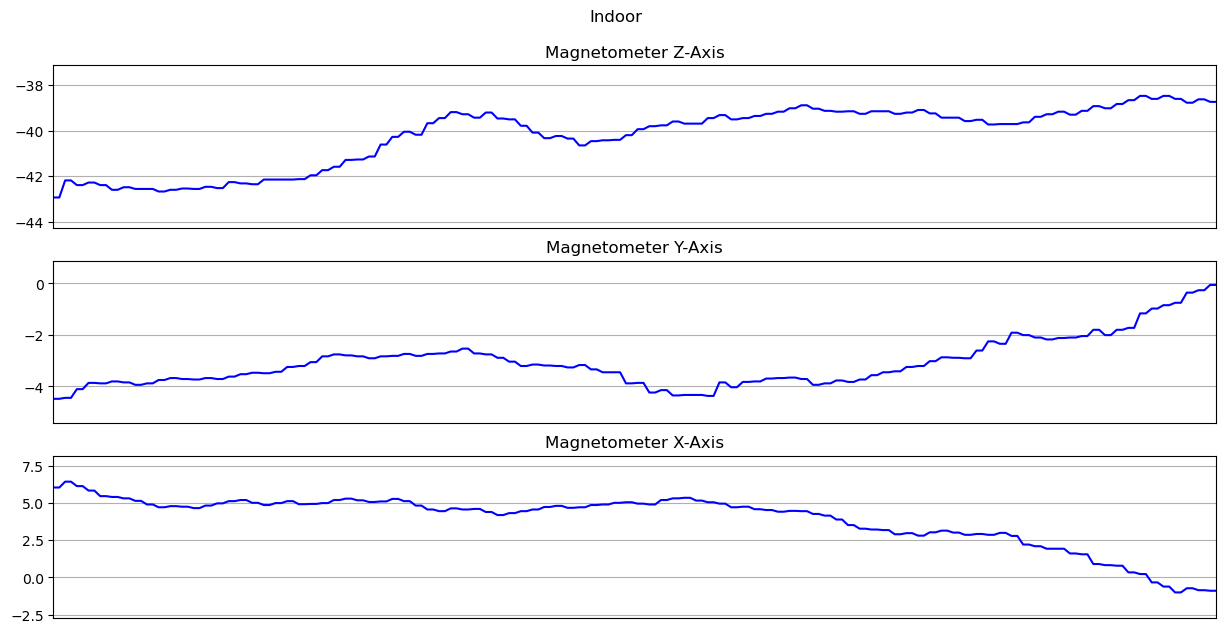

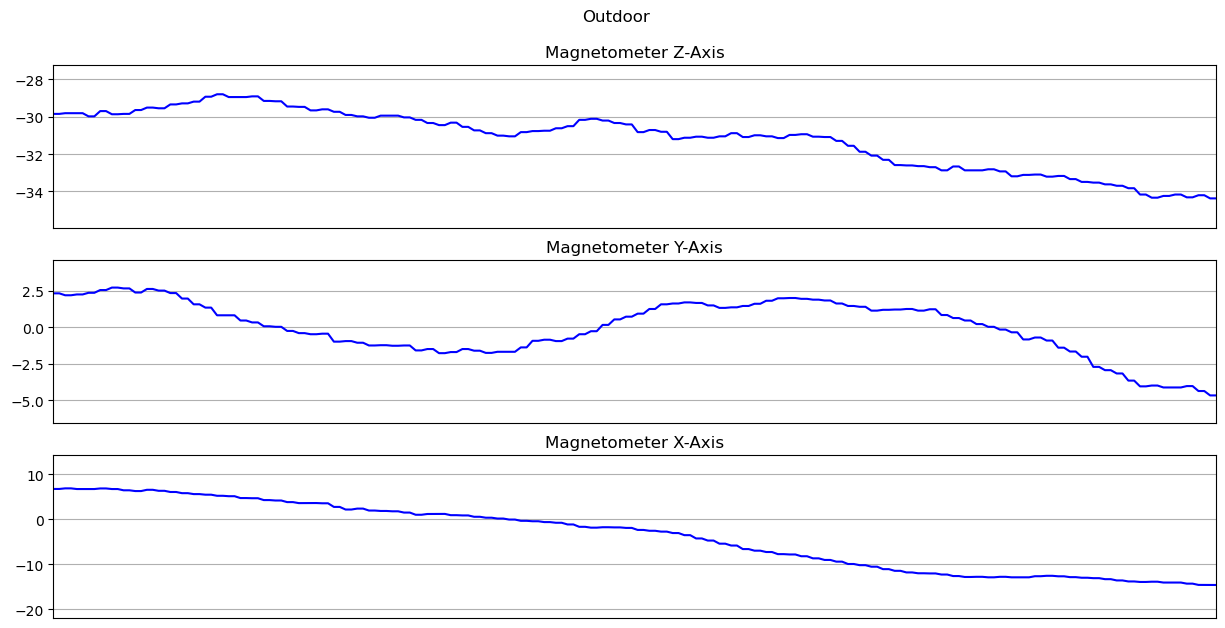

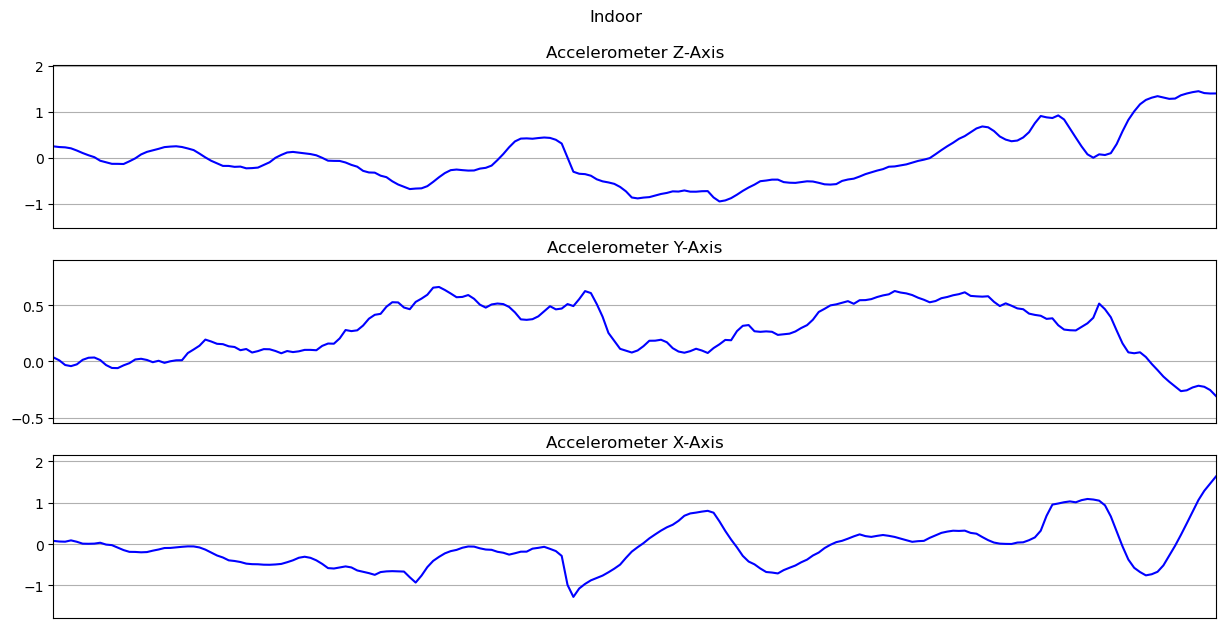

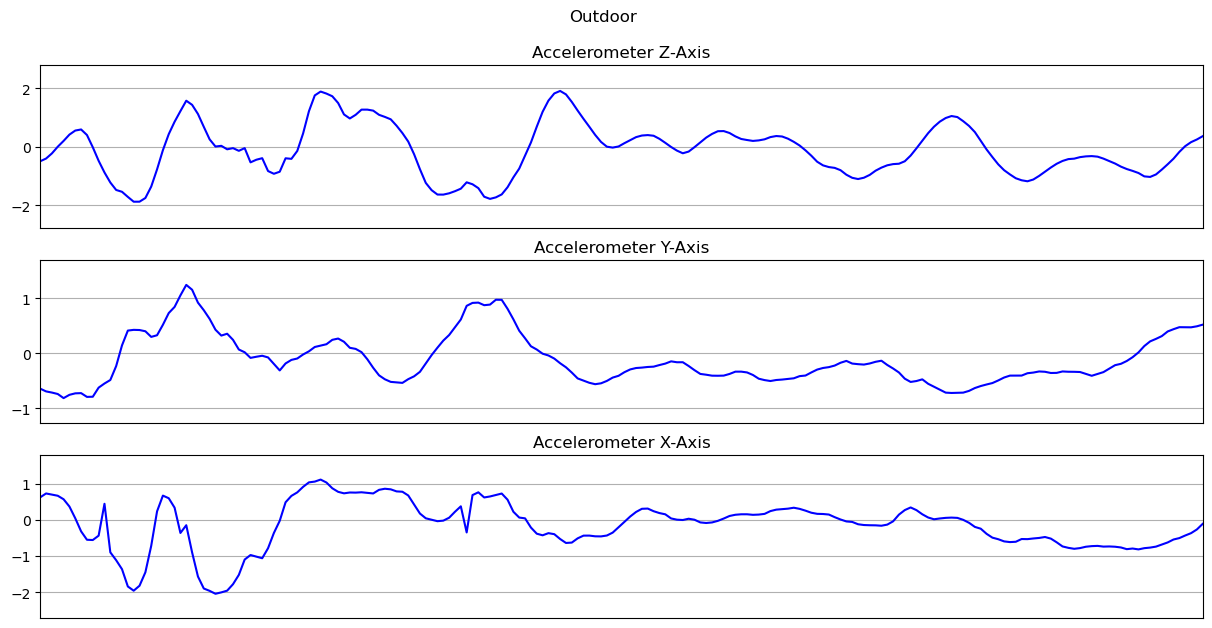

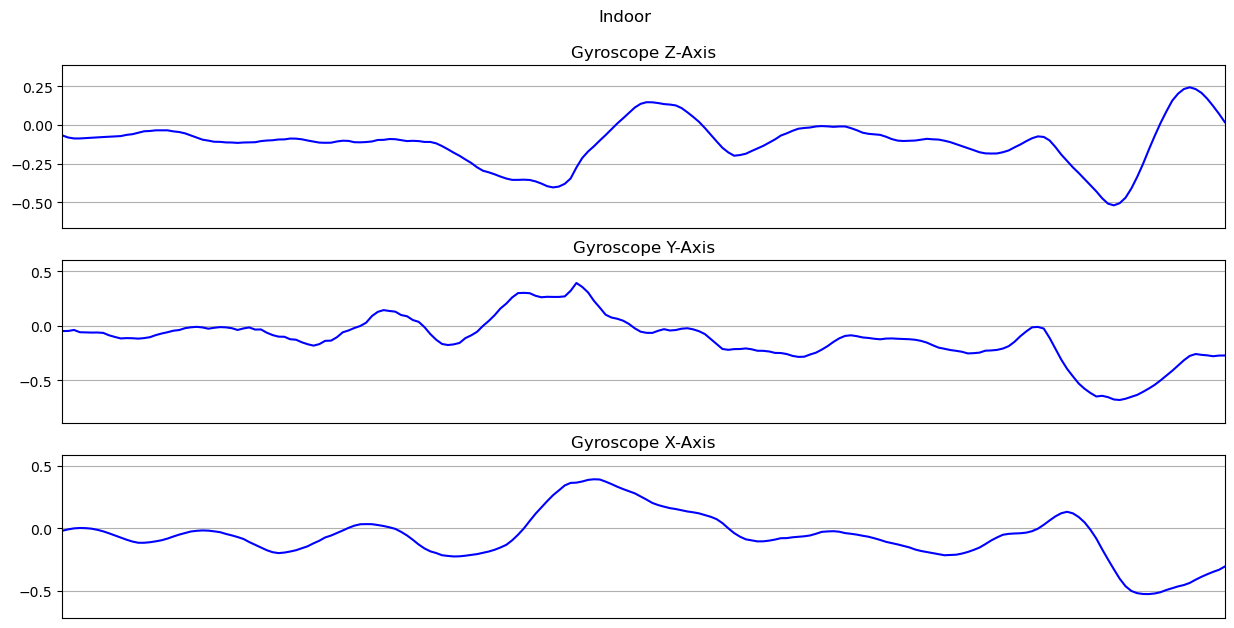

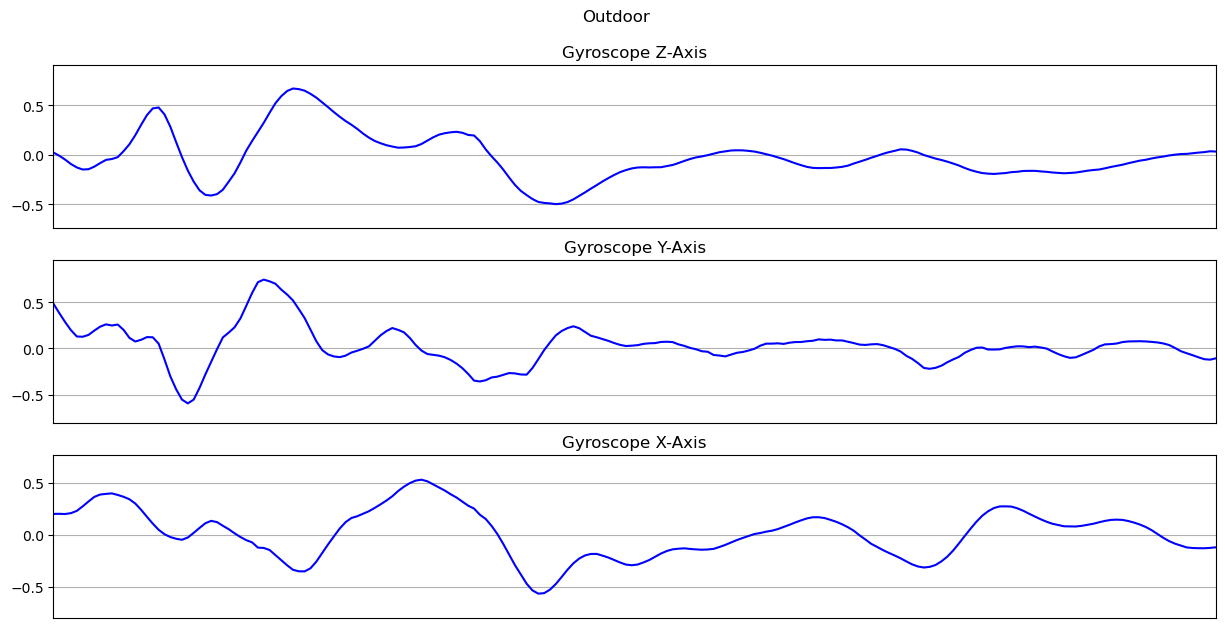

In [9]:
def plot_state(state, data):
    fig, (mx0, mx1, mx2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(mx0, data['index'], data['mag-z'], 'Magnetometer Z-Axis')
    plot_axis(mx1, data['index'], data['mag-y'], 'Magnetometer Y-Axis')
    plot_axis(mx2, data['index'], data['mag-x'], 'Magnetometer X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(mx, x, y, title):
    mx.plot(x, y, 'b')
    mx.set_title(title)
    mx.xaxis.set_visible(False)
    mx.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    mx.set_xlim([min(x), max(x)])
    mx.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

def plot_state(state, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['index'], data['acc-z'], 'Accelerometer Z-Axis')
    plot_axis(ax1, data['index'], data['acc-y'], 'Accelerometer Y-Axis')
    plot_axis(ax2, data['index'], data['acc-x'], 'Accelerometer X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'b')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

def plot_state(state, data):
    fig, (gx0, gx1, gx2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(gx0, data['index'], data['gyro-z'], 'Gyroscope Z-Axis')
    plot_axis(gx1, data['index'], data['gyro-y'], 'Gyroscope Y-Axis')
    plot_axis(gx2, data['index'], data['gyro-x'], 'Gyroscope X-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(state)
    plt.subplots_adjust(top=0.90)
    plt.show()

   

def plot_axis(mx, x, y, title):
    mx.plot(x, y, 'b')
    mx.set_title(title)
    mx.xaxis.set_visible(False)
    mx.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    mx.set_xlim([min(x), max(x)])
    mx.grid(True)

for state in states:
    data_for_plot = data[(data['state'] == state)][:Fs*10]
    plot_state(state, data_for_plot)

Here the MAGNET dataset has an un-equal nuber of values is each label. Hence we need to balance the dataset, otherwise their is a possibility of overfitting for certain labels or low accuracy for certain labels.

###  Balancing the Dataset

As observed "Indoor" has the most values, whereas the label "Outdoor" has the least

In [10]:
df = data.drop(['index', 'timestamp'], axis = 1).copy()
df['state'].value_counts()

Indoor     699739
Outdoor    530828
Name: state, dtype: int64

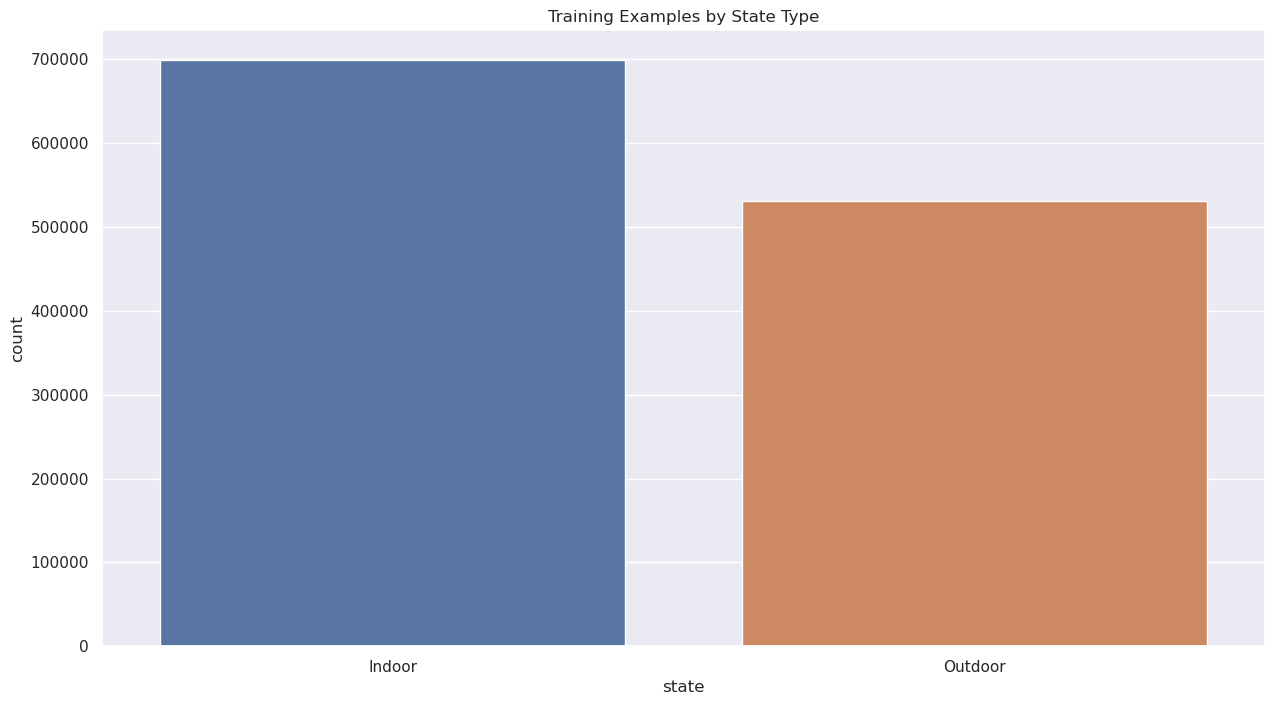

In [11]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'state', data = df)
plt.title('Training Examples by State Type')
plt.show()

Since "Outdoor" has the least quantity of data, we have taken it as a reference for balancing 

In [12]:
Outdoor = df[df['state'] == 'Outdoor'].copy()
Indoor = df[df['state'] == 'Indoor'].head(530828).copy()

In [13]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Outdoor, Indoor])
balanced_data.shape

/tmp/ipykernel_26769/1975575116.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = balanced_data.append([Outdoor, Indoor])


(1061656, 10)

In [14]:
# Displaying the balanced data
print('State Count:',balanced_data['state'].value_counts())

State Count: Outdoor    530828
Indoor     530828
Name: state, dtype: int64


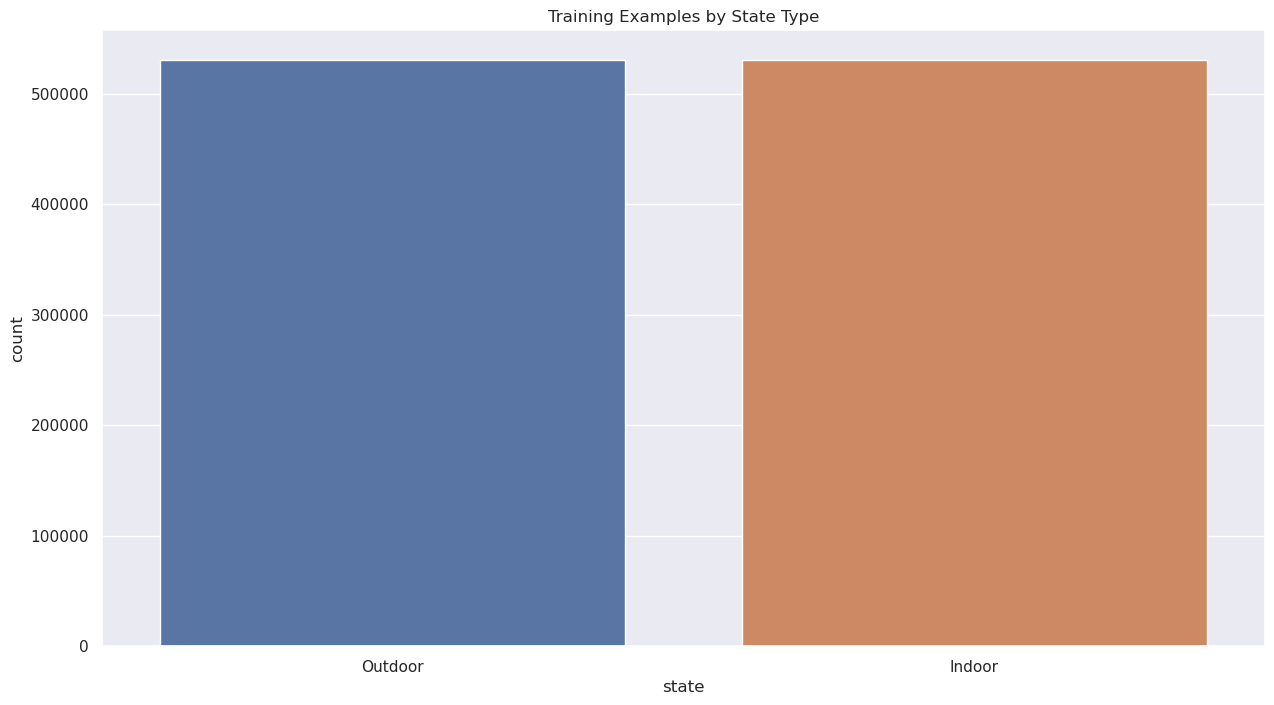

In [15]:
# Analyzing Class Label Distribution
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x = 'state', data = balanced_data)
plt.title('Training Examples by State Type')
plt.show()

In [16]:
# Encoding the Data with suitable labels
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['state'])
balanced_data.head()

,state,mag-z,mag-y,mag-x,acc-z,acc-y,acc-x,gyro-z,gyro-y,gyro-x,label
615056,Outdoor,-29.850000,2.30625,6.76875,-0.496039,-0.642663,0.620323,0.021761,0.484020,0.201809,1
615057,Outdoor,-29.850000,2.30625,6.76875,-0.404016,-0.692411,0.727258,-0.010003,0.382619,0.202420,1
615058,Outdoor,-29.812502,2.17500,6.90000,-0.228154,-0.713446,0.695428,-0.049097,0.285495,0.200587,1
615059,Outdoor,-29.812502,2.17500,6.90000,0.000651,-0.739677,0.664212,-0.093689,0.197533,0.209139,1
615060,Outdoor,-29.812502,2.23125,6.75000,0.199010,-0.814597,0.567077,-0.127896,0.129729,0.231129,1


### Standardizing the Dataset

In [17]:
X = balanced_data[['mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x']]
y = balanced_data['label']

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['mag-z','mag-y','mag-x','acc-z','acc-y','acc-x','gyro-z','gyro-y','gyro-x'])
scaled_X['label'] = y.values

scaled_X

,mag-z,mag-y,mag-x,acc-z,acc-y,acc-x,gyro-z,gyro-y,gyro-x,label
0,-0.869137,0.635887,0.405753,-0.517265,-0.712834,0.707775,0.045720,1.216997,0.499499,1
1,-0.869137,0.635887,0.405753,-0.430168,-0.777701,0.829877,-0.025594,0.960250,0.501028,1
2,-0.867541,0.629642,0.411120,-0.263720,-0.805129,0.793532,-0.113364,0.714330,0.496441,1
3,-0.867541,0.629642,0.411120,-0.047163,-0.839332,0.757889,-0.213478,0.491610,0.517849,1
4,-0.867541,0.632318,0.404986,0.140579,-0.937023,0.646977,-0.290277,0.319930,0.572900,1
...,...,...,...,...,...,...,...,...,...,...
1061651,-1.633647,0.775973,-0.551260,0.249971,-0.435865,-2.166530,-1.353293,-0.012217,-0.046615,0
1061652,-1.644820,0.776865,-0.550493,0.302092,-0.525969,-2.287590,-1.350550,-0.123578,0.019141,0
1061653,-1.644820,0.776865,-0.550493,0.339360,-0.608265,-2.327967,-1.372493,-0.221018,0.101717,0
1061654,-1.653598,0.783111,-0.554328,0.312230,-0.676848,-2.318422,-1.384836,-0.346298,0.201115,0


In [18]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 9

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        mag_z = df['mag-z'].values[i: i + frame_size]
        mag_y = df['mag-y'].values[i: i + frame_size]
        mag_x = df['mag-x'].values[i: i + frame_size]
        acc_z = df['acc-z'].values[i: i + frame_size]
        acc_y = df['acc-y'].values[i: i + frame_size]
        acc_x = df['acc-x'].values[i: i + frame_size]
        gyro_z = df['gyro-z'].values[i: i + frame_size]
        gyro_y = df['gyro-y'].values[i: i + frame_size]
        gyro_x = df['gyro-x'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([mag_z, mag_y, mag_x, acc_z, acc_y, acc_x, gyro_z, gyro_y, gyro_x])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [19]:
scaled_X = scaled_X.replace([np.inf, -np.inf], np.nan)
scaled_X = scaled_X.dropna()
scaled_X = scaled_X.reset_index()
X, y = get_frames(scaled_X, frame_size, hop_size)
X.shape, y.shape

/tmp/ipykernel_26769/3293854193.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


((26540, 80, 9), (26540,))

In [20]:
scaled_X.shape

(1061656, 11)

In [21]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Creating the K-fold cross-validation iterator
kfold = StratifiedKFold(n_splits=fold_number, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Shape of X: (26540, 80, 9)
Shape of y: (26540,)


((21232, 80, 9), (5308, 80, 9), (21232,), (5308,))

In [22]:
#import numpy as npt
#npt.savetxt('X_test.csv', X_test.reshape(X_test.shape[0], -1), delimiter=',')
#npt.savetxt('y_test.csv', y_test, delimiter=',')


In [23]:
from keras.layers import Input


n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = 2#y_train.shape[1]

input_shape=(n_timesteps,n_features)
inputs = Input(shape=input_shape)

print("input_shape = ",input_shape)
print("n_outputs = ",n_outputs)

input_shape =  (80, 9)
n_outputs =  2


<h2><b>Propose Model</h2></b>

In [24]:
# Define the CNN-LSTM model with 2 parallel 1D CNN branches
def parallel_CNN_LSTM(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # First 1D CNN branch
    x1 = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x1 = MaxPooling1D(2)(x1)
    x1 = LSTM(64)(x1)

    # Second 1D CNN branch
    x2 = Conv1D(64, kernel_size=5, activation='relu')(inputs)
    x2 = MaxPooling1D(2)(x2)
    x2 = LSTM(64)(x2)

    # Concatenate the outputs from both branches
    x = concatenate([x1, x2])

    x = Dropout(0.2)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [25]:
# Function to train the model using K-fold cross-validation
def trainingModel(model_path, X, y, fold_number=6, epoch_number=100, batch_number=64):
    # Create KFold instance
    kfold = KFold(n_splits=fold_number, shuffle=True)

    # Create empty lists to store the fold models and evaluation results
    fold_models = []
    fold_test_acc = []
    fold_test_f1 = []
    fold_prediction_times = []
    fold_training_times = []

    # Looping over the folds
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}:")

        # Get the train and validation sets for this fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Define the filepath for the saved model specific to this fold
        filepath = model_path + f"bd_MAGNet_V{version}_W_{window_size}_F_{fold+1}.h5"

        # Define early stopping based on validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Define a checkpoint to monitor the validation accuracy and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        input_shape = X_train[0].shape
        # Create the CNN-LSTM model with parallel 1D CNNs
        model = parallel_CNN_LSTM(input_shape, outputs_class)

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Start the training time measurement
        start_time = time.time()

        # Train the model with the checkpoint callback for this fold
        history = model.fit(X_train_fold, y_train_fold, epochs=epoch_number, batch_size=batch_number,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop], verbose=1)

        # End the training time measurement
        end_time = time.time()
        training_time = end_time - start_time

        # Save the fold model to the list
        fold_models.append(model)

        # Evaluate the model on the test set
        test_pred = model.predict(X_test)
        test_pred_labels = np.argmax(test_pred, axis=1)

        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            test_true_labels = np.argmax(y_test, axis=1)
        else:
            test_true_labels = y_test

        test_acc = accuracy_score(test_true_labels, test_pred_labels)
        test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

        # Calculate the prediction time
        start_time = time.time()
        model.predict(X_test[:1])
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds

        # Save the evaluation results and times to the lists
        fold_test_acc.append(test_acc)
        fold_test_f1.append(test_f1)
        fold_prediction_times.append(prediction_time)
        fold_training_times.append(training_time)

    # Calculate mean and median times for prediction and training
    mean_prediction_time = np.mean(fold_prediction_times) / 1000  # Convert back to seconds
    median_prediction_time = np.median(fold_prediction_times) / 1000  # Convert back to seconds
    mean_training_time = np.mean(fold_training_times)
    median_training_time = np.median(fold_training_times)

    # Calculate the total number of parameters
    total_params = model.count_params()

    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes

    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)

    # Save the averaged model
    averaged_model = fold_models[0]
    averaged_weights = averaged_model.get_weights()

    n_splits = fold_number
    # Loop over the layers of the models and average the weights
    for layer in range(len(averaged_weights)):
        for fold in range(1, n_splits):
            averaged_weights[layer] += fold_models[fold].get_weights()[layer]

        averaged_weights[layer] /= n_splits

    # Set the averaged weights to the averaged model
    averaged_model.set_weights(averaged_weights)
    averaged_filepath = model_path + f"bd_MAGNet_V{version}_W_{window_size}.h5"
    averaged_model.save(averaged_filepath)

    return averaged_model, fold_test_acc, fold_test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb


In [26]:
# Train the model and get the required outputs
trained_model, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train)


Fold 1:


2023-08-23 21:43:38.538185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 21:43:38.538333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-23 21:43:38.538366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-23 21:43:38.538391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-23 21:43:38.538415: W tensorflow/c

Epoch 1/100
277/277 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8809
Epoch 1: val_accuracy improved from -inf to 0.93331, saving model to /home/bilz/air/models/bd_MAGNet_V1_W_6_F_1.h5
277/277 [==============================] - 6s 17ms/step - loss: 0.3065 - accuracy: 0.8809 - val_loss: 0.2070 - val_accuracy: 0.9333
Epoch 2/100
277/277 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9347
Epoch 2: val_accuracy improved from 0.93331 to 0.93699, saving model to /home/bilz/air/models/bd_MAGNet_V1_W_6_F_1.h5
277/277 [==============================] - 4s 16ms/step - loss: 0.1968 - accuracy: 0.9347 - val_loss: 0.1932 - val_accuracy: 0.9370
Epoch 3/100
277/277 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9396
Epoch 3: val_accuracy improved from 0.93699 to 0.94151, saving model to /home/bilz/air/models/bd_MAGNet_V1_W_6_F_1.h5
277/277 [==============================] - 4s 16ms/step - loss: 0.1815 - accuracy: 0.9396 - va

## Display the Results

In [27]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [0.941785983421251, 0.944800301431801, 0.9495101733232856, 0.9498869630746044, 0.9464958553127355, 0.9478146194423511]
F1-score: [0.9417688684495383, 0.9447544007938489, 0.9494789299027184, 0.949851072822655, 0.9464507806218063, 0.9477856628156749]
Mean Prediction Time (sec): 0.027890
Median Prediction Time (sec): 0.027815
Mean Training Time (sec): 183.193803
Median Training Time (sec): 169.708447
Mean Single Prediction Time (msec): 27.890
Median Single Prediction Time (msec): 27.815
Mean Required Memory (Mb): 0.2710
Median Required Memory (Mb): 0.2710
Mean Model Parameters (K): 69.38
Median Model Parameters (K): 69.38


## Confusion Matrix

In [28]:
# Function to draw the confusion matrix and ROC curve
def drawConfusionMatrix(myModel, X_test, y_test):
    class_labels = ['Outdoor', 'Indoor']
    # Measure the time it takes to predict a single sample
    start_time = time.time()
    predict_x = myModel.predict(X_test)
    end_time = time.time()

    # Calculate the prediction time
    prediction_time = end_time - start_time
    print('Prediction time:', prediction_time, 'seconds')

    y_pred = np.argmax(predict_x, axis=1)
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
    plt.title("Confusion matrix", fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Calculate ROC curve and AUC
    y_prob = predict_x[:, 1]  # Probability for the positive class (Indoor)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

  1/166 [..............................] - ETA: 2s

166/166 [==============================] - 1s 4ms/step
Prediction time: 0.7934479713439941 seconds


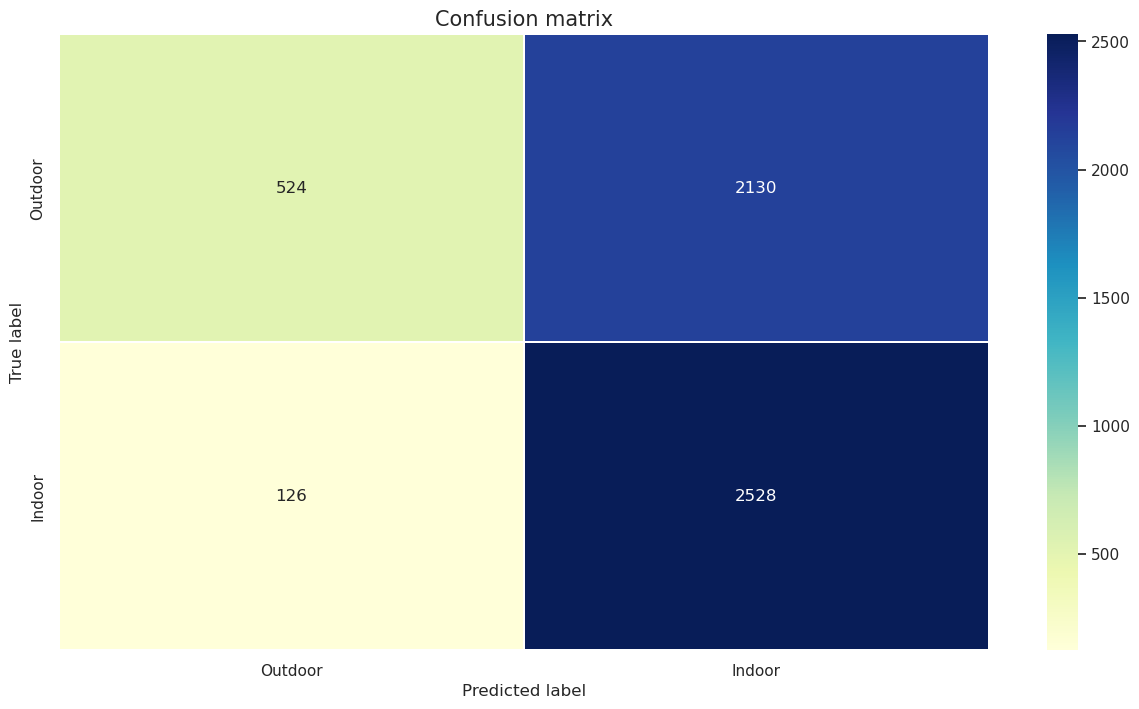

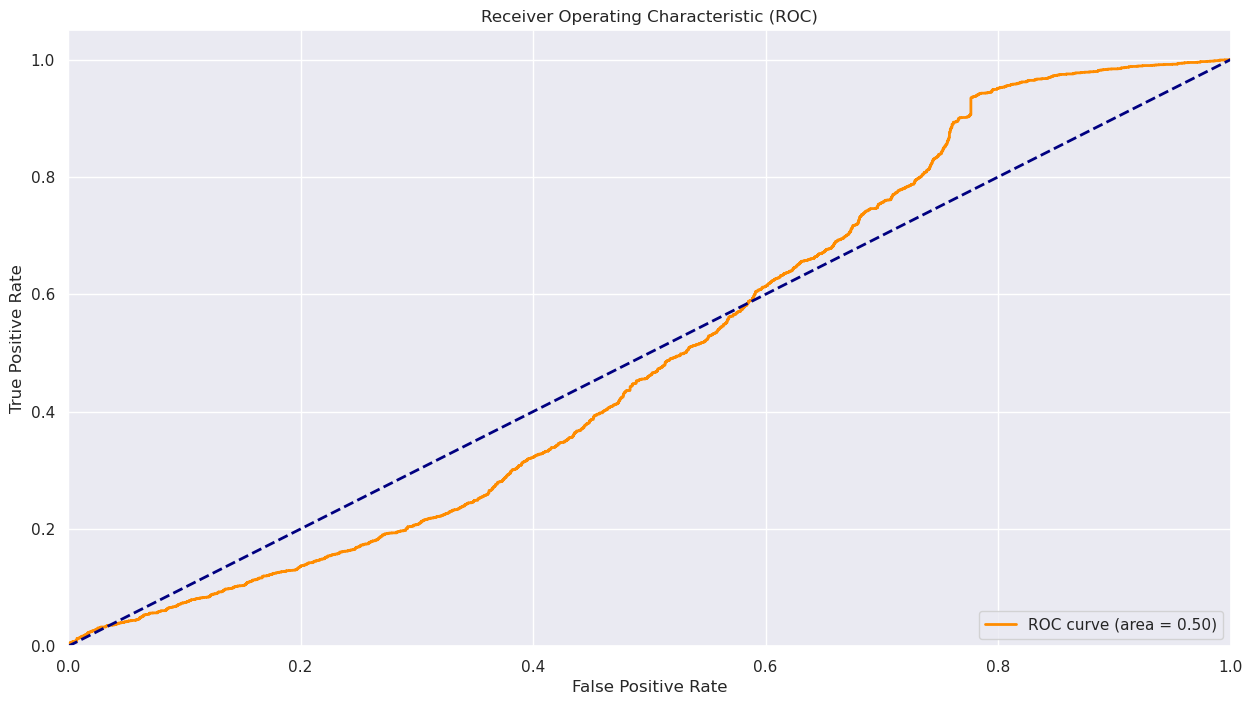

In [29]:
# Display confusion matrix and ROC curve
drawConfusionMatrix(trained_model, X_test, y_test)